In [9]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [10]:

df = {} # This will store the DataFrame for gemma3-1b-stats.txt

# --- Define the specific file you want to process ---
file_name = "gemma3-4b-stats.txt"

# Construct the full absolute path to the file
# Using pathlib for cross-platform compatibility and readability
home_directory = Path.home()
file_path_to_process = home_directory / "Downloads" / file_name

# Define the columns that will be in the DataFrame
columns = ['total duration', 'load duration', 'prompt eval count', 'prompt eval duration',
           'prompt eval rate', 'eval count', 'eval duration', 'eval rate']

# The pattern to extract numeric values and time units (h, m, s, ms)
pattern = r"\s(\d+h)?(\d+m)?(\d+(\.?\d+)?)\s*(s|ms)?"

# --- Start processing the single file ---
rows = []
current_row = []

# Check if the file exists before trying to open it
if not os.path.exists(file_path_to_process):
    print(f"Error: The file '{file_path_to_process}' was not found.")
    print("Please ensure the file name is correct and it is located in your default Downloads folder.")
else:
    try:
        with open(file_path_to_process, 'r', errors="replace") as file:
            for line in file:
                result = re.search(pattern, line)
                if not result:
                    continue

                groups = result.groups()

                # Logic to convert extracted groups into seconds
                value_in_seconds = 0.0
                if groups[0] is not None: # Hours
                    hours = int(groups[0][:-1])
                    value_in_seconds += hours * 3600
                if groups[1] is not None: # Minutes
                    minutes = int(groups[1][:-1])
                    value_in_seconds += minutes * 60
                                
                seconds_str = groups[2]
                unit = groups[4] # 's' or 'ms' or None if only seconds without explicit unit

                if unit == "ms":
                    milliseconds = float(seconds_str)
                    value_in_seconds += milliseconds / 1000
                else: # Default to seconds if unit is 's' or not specified
                    value_in_seconds += float(seconds_str)
                
                current_row.append(value_in_seconds)

                # If we have collected enough values for one row, add it and reset
                if len(current_row) == len(columns):
                    rows.append(current_row)
                    current_row = []
        
        # Create a DataFrame for the processed file
        if rows: # Only create DataFrame if there's data
            # Use the simple file_name as the key in the df dictionary
            df[file_name] = pd.DataFrame(rows, columns=columns)
        else:
            print(f"No data found in {file_name} to create a DataFrame (or no lines matched the pattern).")

    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_name}': {e}")

print(df)

# You can now access the DataFrame directly:
# if file_name in df:
#     print("\nDataFrame for gemma3-1b-stats.txt:")
#     print(df[file_name])

{'gemma3-4b-stats.txt':     total duration  load duration  prompt eval count  prompt eval duration  \
0         200.8700         1.0000          6753.0000                9.7000   
1           0.9591         0.5511             1.8100                2.0000   
2           0.4144         1.6900             3.0000                2.0000   
3         150.0000        32.0000           110.0000               61.2917   
4          24.0000        72.0000            39.8663                1.2165   
5         111.0000        61.4627             1.2100                0.5478   
6          90.4425         0.9830             0.5522                1.8000   
7           1.0000         1.0000             1.0000              120.0000   
8         277.0021         0.9699             0.5521                1.8100   
9           0.9716         0.5479             1.8100                9.0000   
10          0.5513         1.7900            10.0000                8.0000   
11          1.8100        11.0000       


--- Generating Additional Visualizations ---
Creating a Correlation Heatmap...


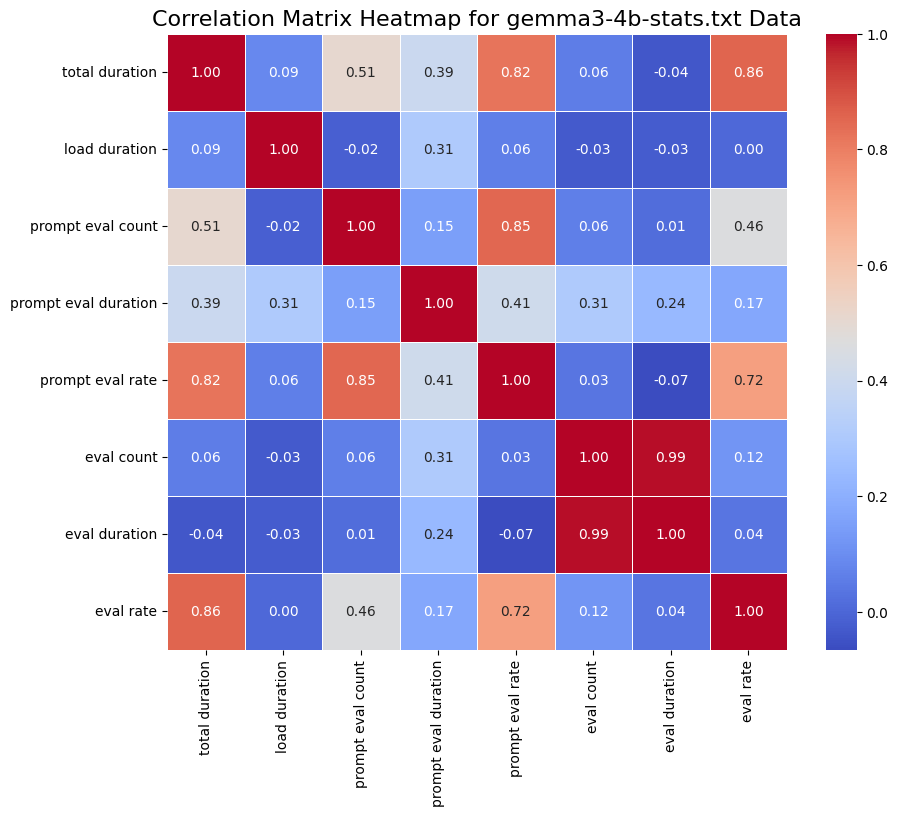

Creating Box Plots for each variable (with outlier capping)...


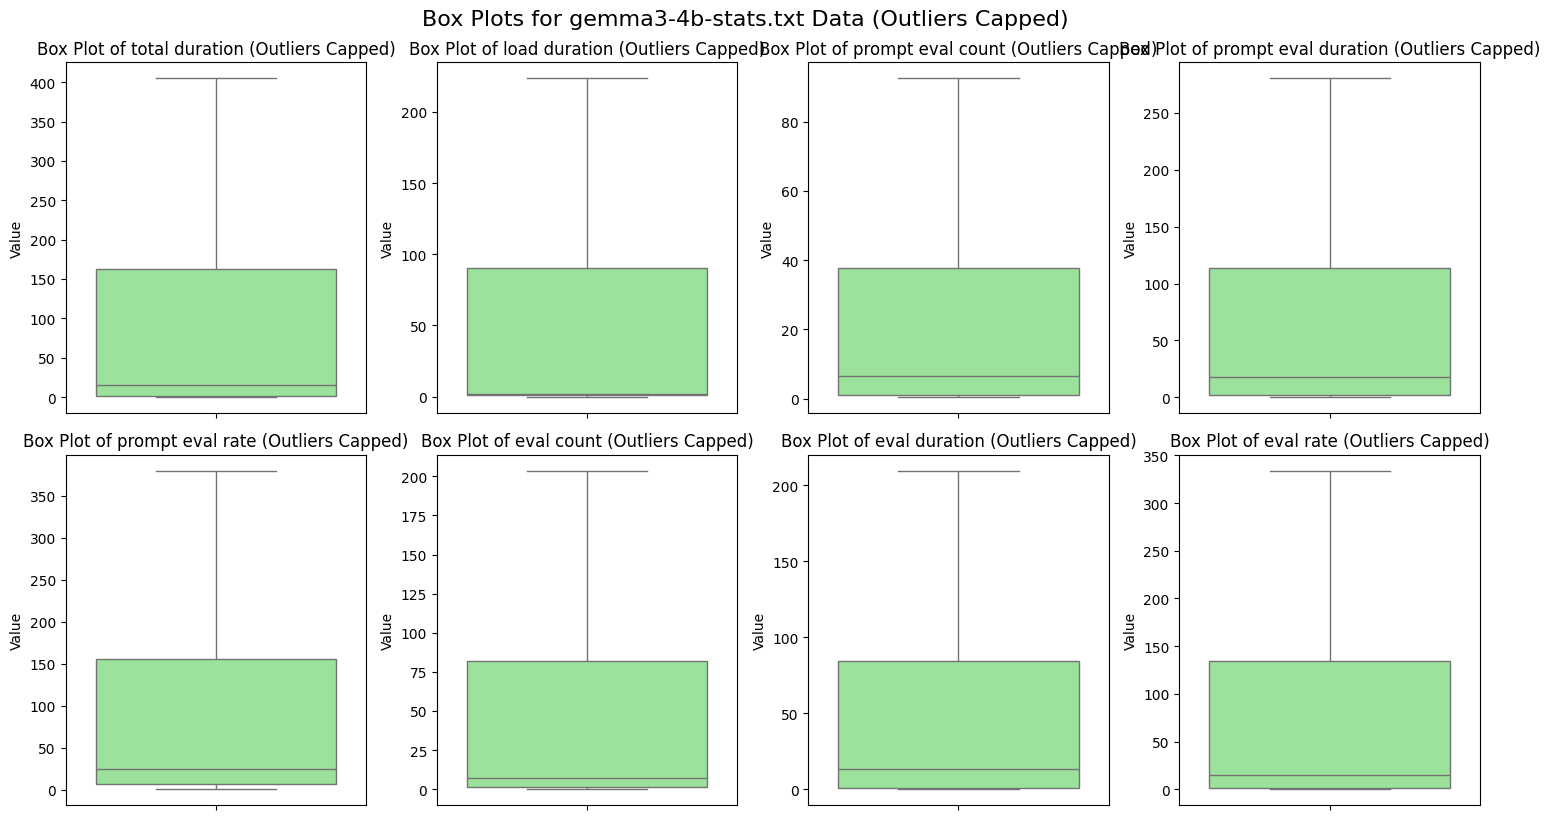

Creating Histograms for each variable (with outlier capping)...


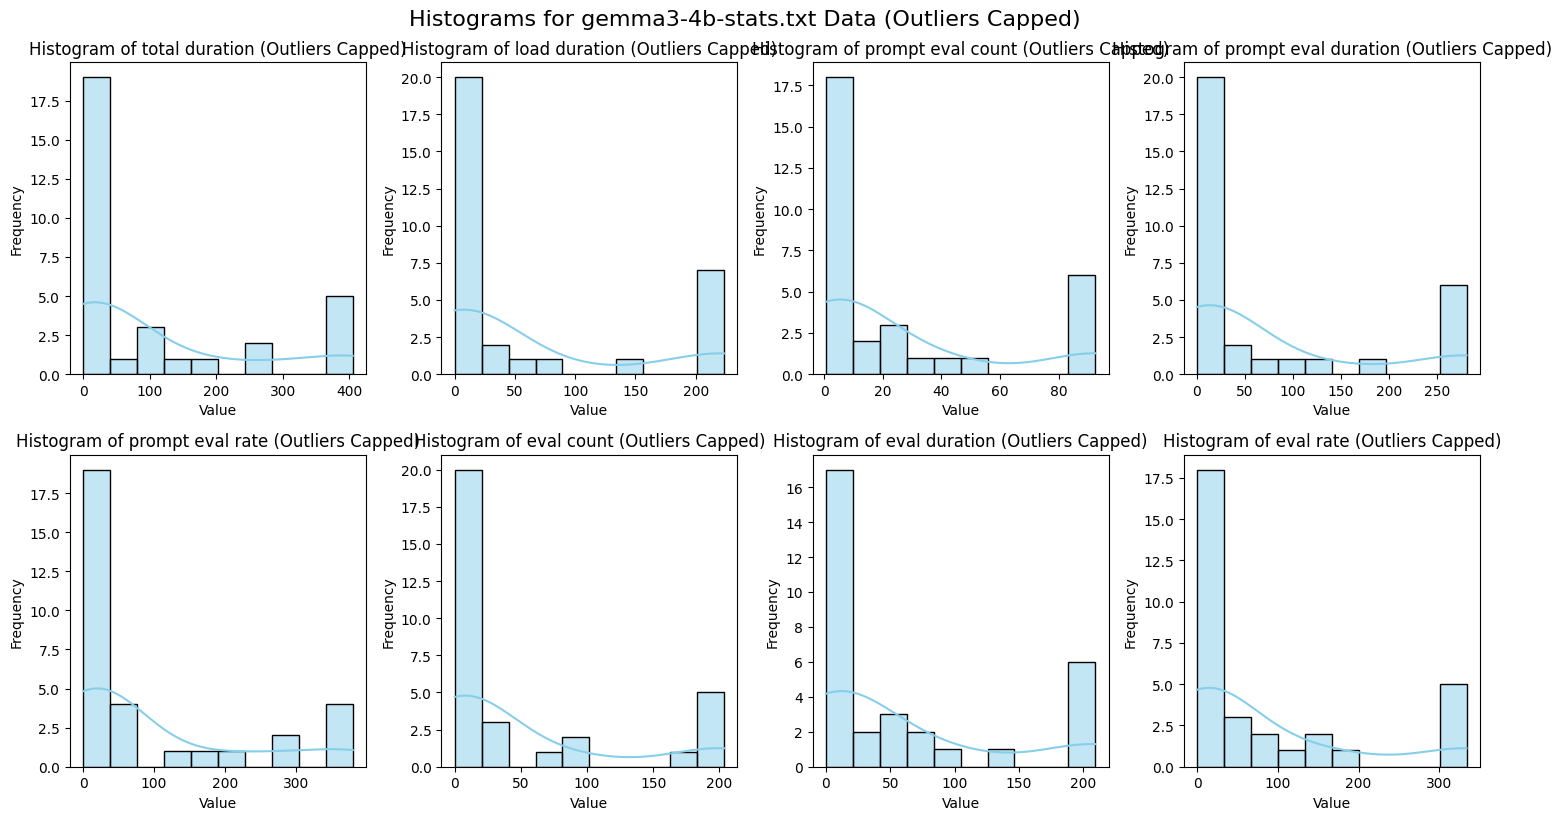

Additional visualizations generated successfully!


In [37]:

def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip values to the defined bounds
    return series.clip(lower=lower_bound, upper=upper_bound)


# Assuming 'df' is populated by your previous script
# For demonstration, let's assume one file name exists
# Replace with the actual file name you want to visualize from your 'df'
file_name = "gemma3-4b-stats.txt" # Make sure this matches a key in your df dictionary

# Safely get the DataFrame for the specified file
# If the file_name key doesn't exist, it will create an empty DataFrame,
# which the 'if not data_frame.empty' check will handle.
data_frame = df.get(file_name, pd.DataFrame())

if not data_frame.empty:
    print("\n--- Generating Additional Visualizations ---")

    # 1. Correlation Heatmap
    print("Creating a Correlation Heatmap...")
    plt.figure(figsize=(10, 8))
    # Calculate the correlation matrix
    correlation_matrix = data_frame.corr()
    # Create the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix Heatmap for {file_name} Data', fontsize=16)
    plt.show()

    # 2. Box Plots for each variable with outlier capping
    print("Creating Box Plots for each variable (with outlier capping)...")
    plt.figure(figsize=(15, 8)) # Adjust figure size
    for i, col in enumerate(data_frame.columns):
        plt.subplot(2, 4, i + 1) # Arrange in 2 rows, 4 columns
        # Apply outlier capping to the current column's data before plotting
        capped_data = cap_outliers_iqr(data_frame[col])
        sns.boxplot(y=capped_data, color='lightgreen') # Use capped data for box plot
        plt.title(f'Box Plot of {col} (Outliers Capped)') # Indicate capping in title
        plt.ylabel('Value')
    plt.tight_layout()
    plt.suptitle(f'Box Plots for {file_name} Data (Outliers Capped)', y=1.02, fontsize=16) # Overall title
    plt.show()

    # 3. Histograms for each variable with outlier capping
    print("Creating Histograms for each variable (with outlier capping)...")
    plt.figure(figsize=(15, 8)) # Adjust figure size

    for i, col in enumerate(data_frame.columns):
        plt.subplot(2, 4, i + 1) # Arrange in 2 rows, 4 columns

        # Apply outlier capping to the current column's data before plotting
        # This creates a new Series with capped values for visualization
        capped_data = cap_outliers_iqr(data_frame[col])

        # Use sns.histplot for histograms with the capped data
        sns.histplot(capped_data, kde=True, color='skyblue', bins=10) # kde=True for density curve
        plt.title(f'Histogram of {col} (Outliers Capped)') # Indicate capping in title
        plt.xlabel('Value') # Label for the x-axis
        plt.ylabel('Frequency') # Label for the y-axis
    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.suptitle(f'Histograms for {file_name} Data (Outliers Capped)', y=1.02, fontsize=16) # Overall title
    plt.show()

    print("Additional visualizations generated successfully!")
else:
    print("\nNo data to visualize. Please ensure the main script ran correctly and populated the DataFrame.")



--- Generating Additional Visualizations ---
Creating Histograms for each variable (with outlier capping)...


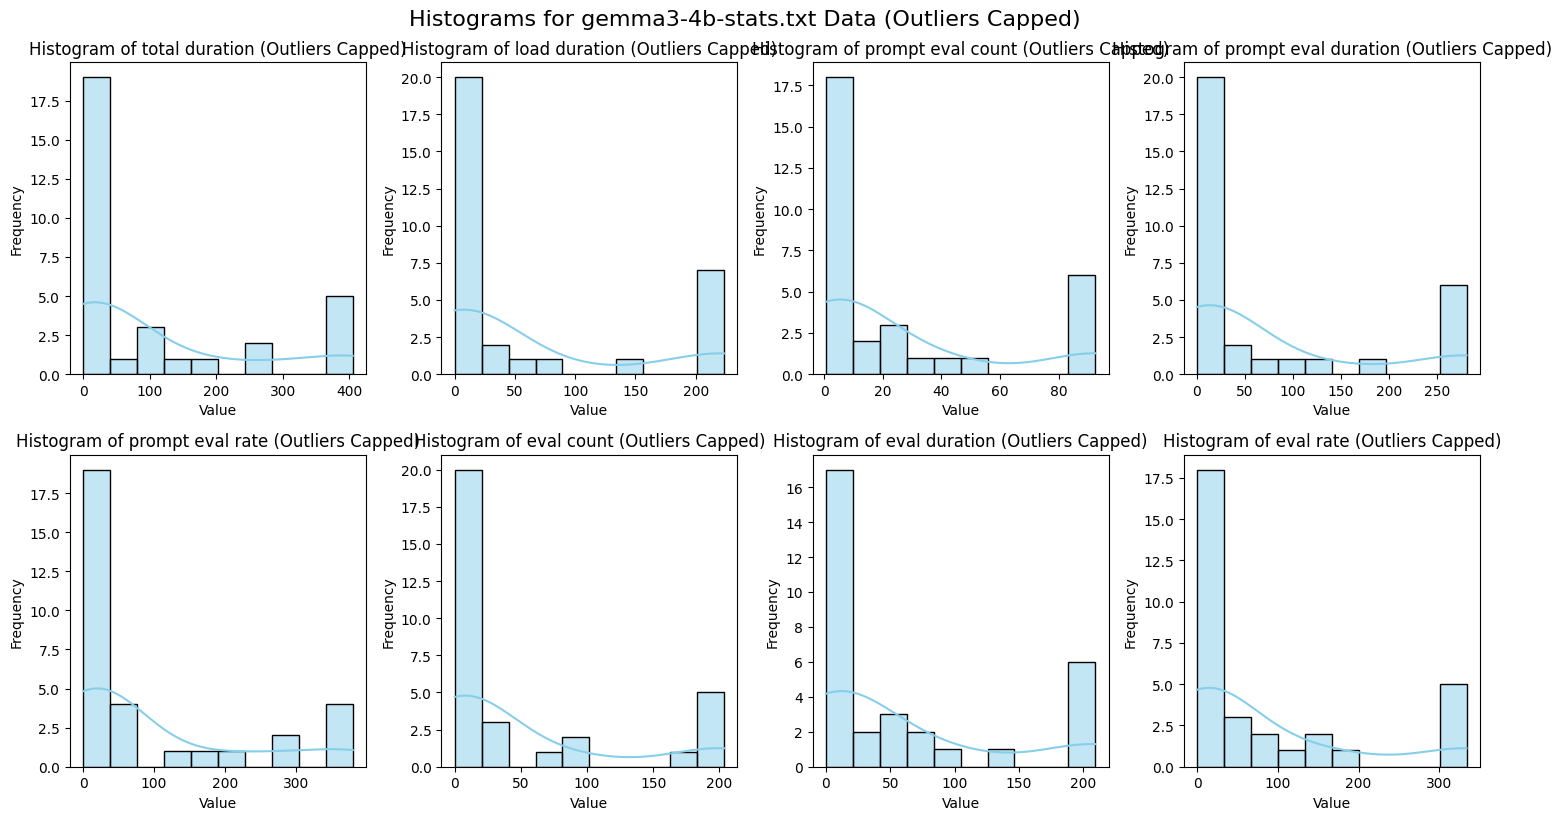

Additional visualizations generated successfully!


In [ ]:
def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip values to the defined bounds
    return series.clip(lower=lower_bound, upper=upper_bound)


# Assuming 'df' is populated by your previous script
# For demonstration, let's assume one file name exists
# Replace with the actual file name you want to visualize from your 'df'
file_name = "gemma3-4b-stats.txt" # Make sure this matches a key in your df dictionary

# Safely get the DataFrame for the specified file
# If the file_name key doesn't exist, it will create an empty DataFrame,
# which the 'if not data_frame.empty' check will handle.
data_frame = df.get(file_name, pd.DataFrame())

if not data_frame.empty:
    print("\n--- Generating Additional Visualizations ---")


    # Histograms for each variable with outlier capping
    print("Creating Histograms for each variable (with outlier capping)...")
    plt.figure(figsize=(15, 8)) # Adjust figure size

    for i, col in enumerate(data_frame.columns):
        plt.subplot(2, 4, i + 1) # Arrange in 2 rows, 4 columns

        # Apply outlier capping to the current column's data before plotting
        # This creates a new Series with capped values for visualization
        capped_data = cap_outliers_iqr(data_frame[col])

        # Use sns.histplot for histograms with the capped data
        sns.histplot(capped_data, kde=True, color='skyblue', bins=10) # kde=True for density curve
        plt.title(f'Histogram of {col} (Outliers Capped)') # Indicate capping in title
        plt.xlabel('Value') # Label for the x-axis
        plt.ylabel('Frequency') # Label for the y-axis
    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.suptitle(f'Histograms for {file_name} Data (Outliers Capped)', y=1.02, fontsize=16) # Overall title
    plt.show()

    print("Additional visualizations generated successfully!")
else:
    print("\nNo data to visualize. Please ensure the main script ran correctly and populated the DataFrame.")



--- Generating Additional Visualizations ---
Creating Scatter Plots for pairwise relationships (with outlier capping)...


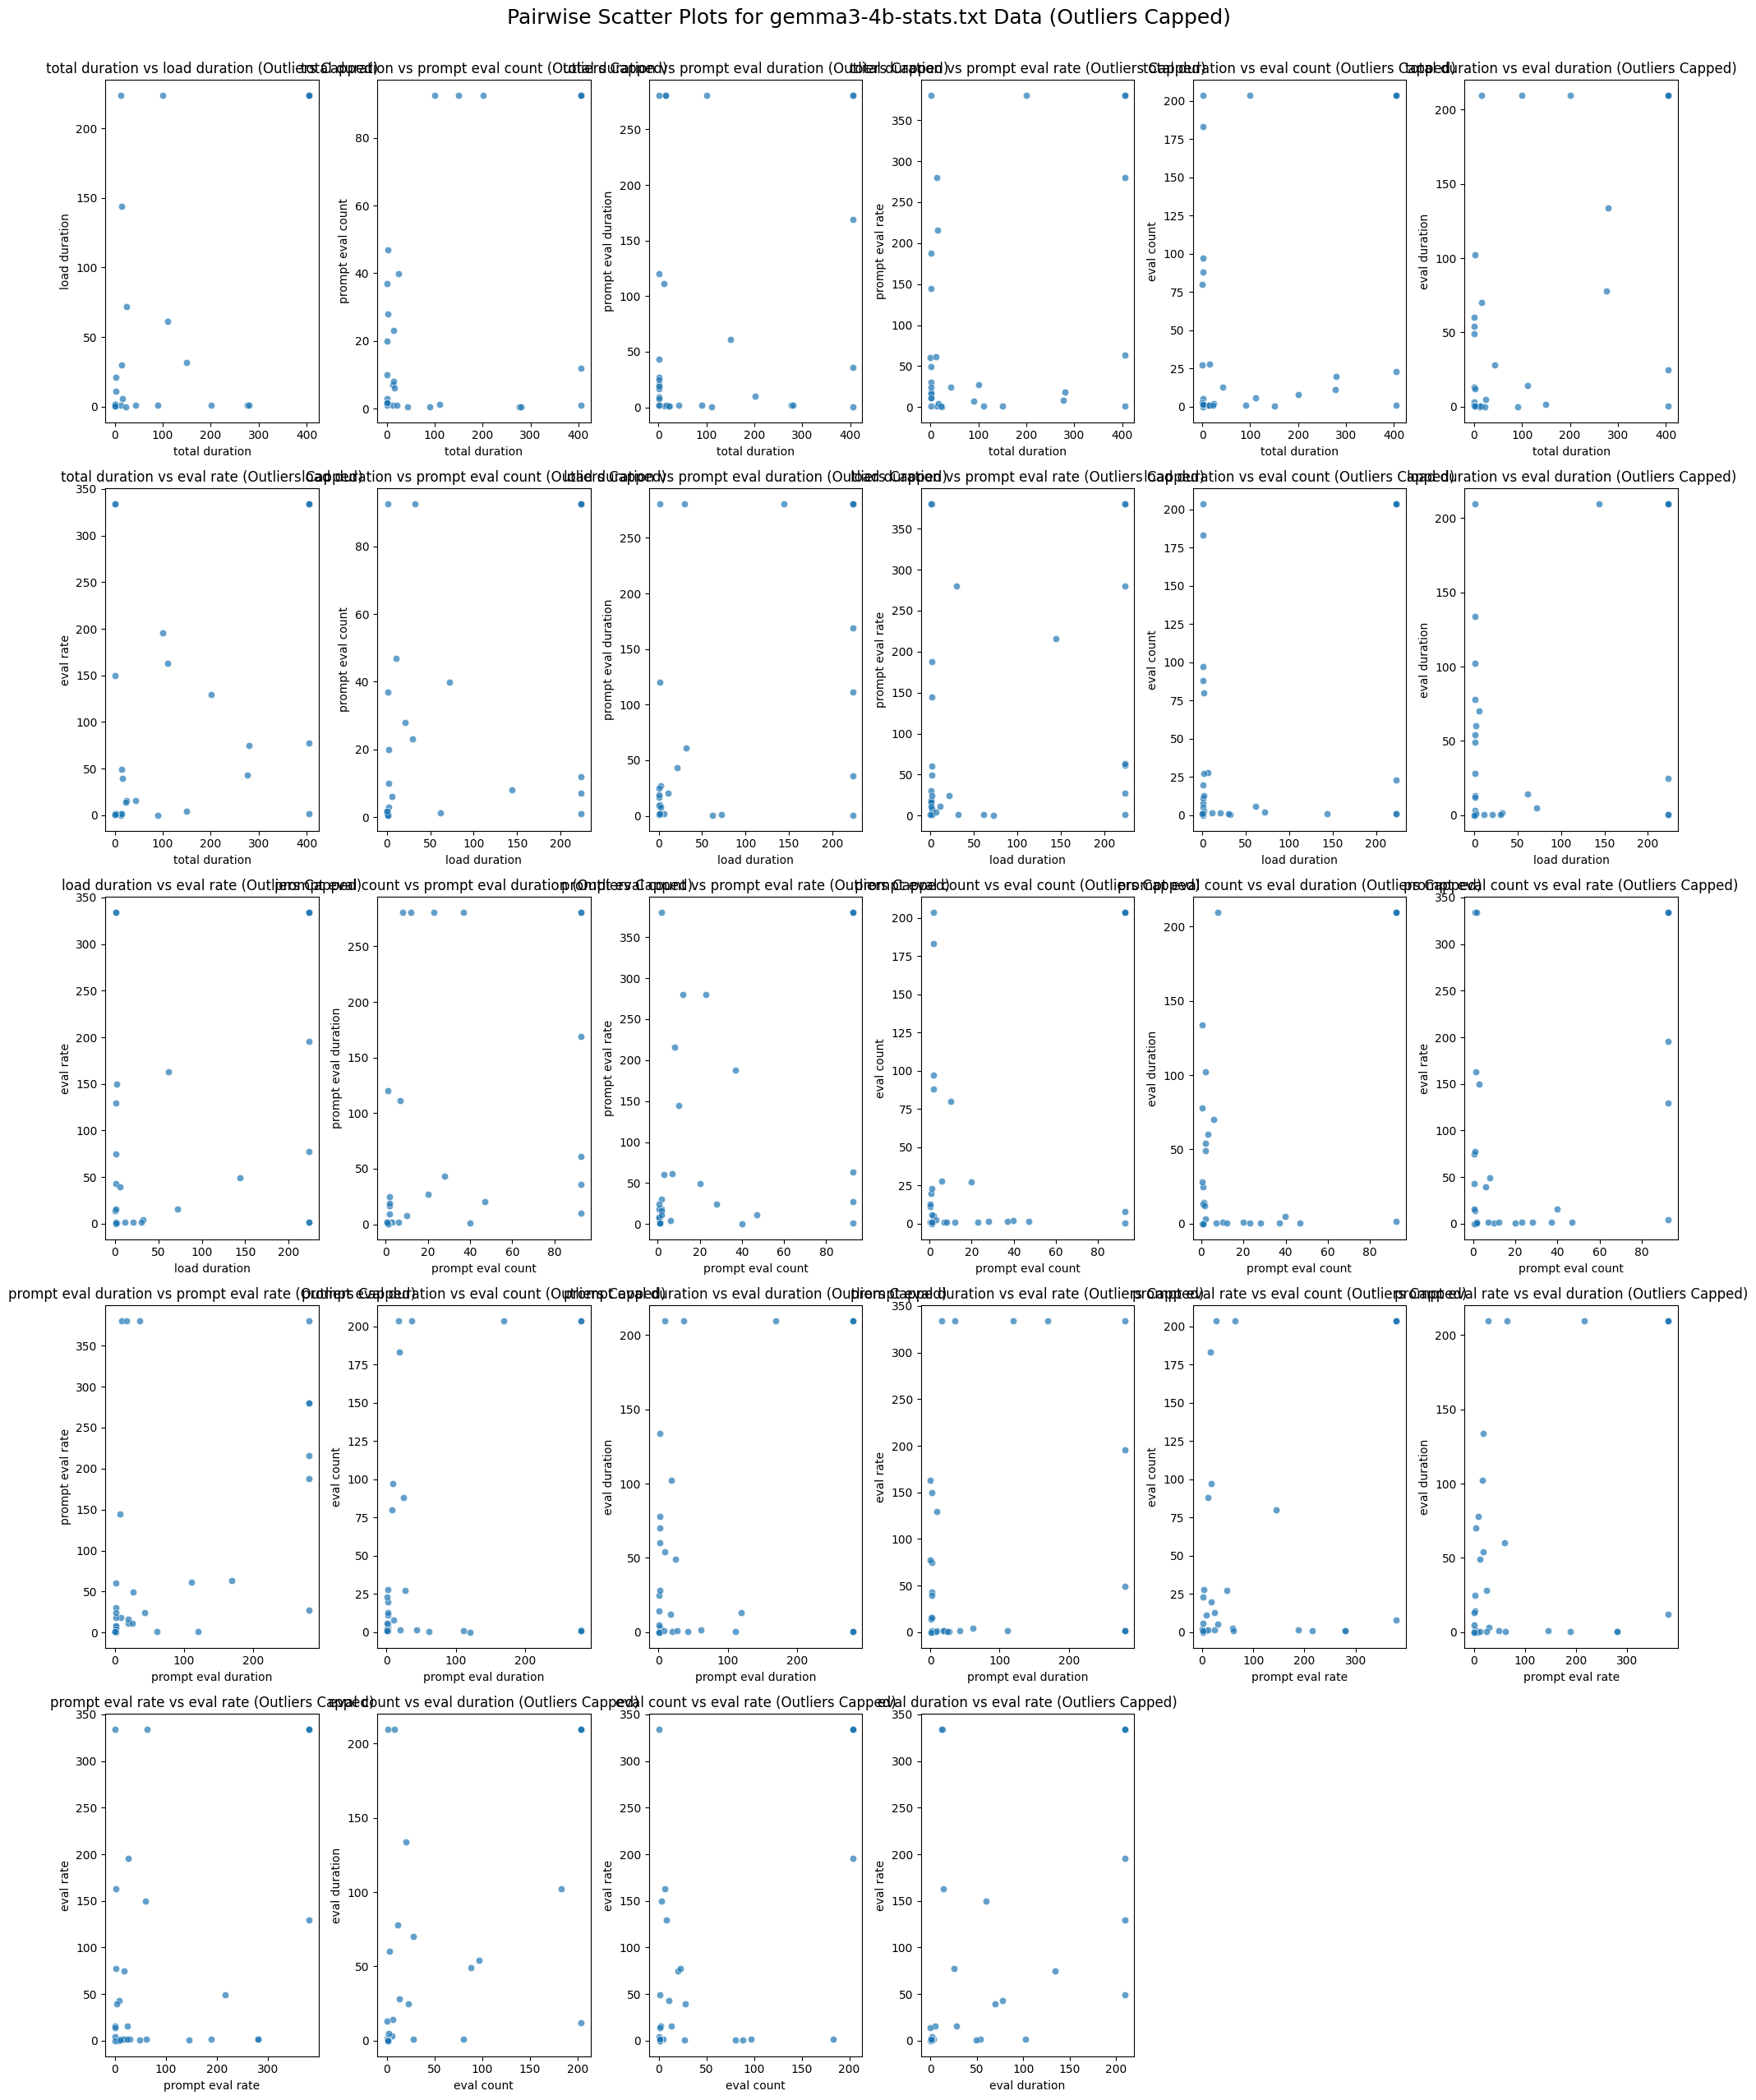

Additional visualizations generated successfully!


In [38]:
def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip values to the defined bounds
    return series.clip(lower=lower_bound, upper=upper_bound)


# Assuming 'df' is populated by your previous script
# For demonstration, let's assume one file name exists
# Replace with the actual file name you want to visualize from your 'df'
file_name = "gemma3-4b-stats.txt" # Make sure this matches a key in your df dictionary

# Safely get the DataFrame for the specified file
# If the file_name key doesn't exist, it will create an empty DataFrame,
# which the 'if not data_frame.empty' check will handle.
data_frame = df.get(file_name, pd.DataFrame())

if not data_frame.empty:
    print("\n--- Generating Additional Visualizations ---")


    # Scatter Plots for pairwise relationships with outlier capping
    print("Creating Scatter Plots for pairwise relationships (with outlier capping)...")
    # Determine the number of subplots needed
    num_cols = len(data_frame.columns)
    # Number of unique pairs = n * (n - 1) / 2
    num_scatter_plots = num_cols * (num_cols - 1) // 2
    
    # Adjust figure size based on the number of plots for better readability
    # A simple heuristic: 5x5 inches per plot, arranged in a reasonable grid
    # For example, if 8 columns, (8*7)/2 = 28 scatter plots.
    # 5 rows x 6 columns for 28 plots would be reasonable
    rows = (num_scatter_plots + 5) // 6 # Roughly 6 plots per row
    plt.figure(figsize=(20, 5 * rows)) # Adjust height dynamically

    plot_index = 1
    # Iterate through all unique pairs of columns
    for i in range(num_cols):
        for j in range(i + 1, num_cols):
            col1 = data_frame.columns[i]
            col2 = data_frame.columns[j]

            plt.subplot(rows, 6, plot_index) # Arrange plots in a grid
            
            # Apply outlier capping to both columns for the scatter plot
            capped_col1_data = cap_outliers_iqr(data_frame[col1])
            capped_col2_data = cap_outliers_iqr(data_frame[col2])

            sns.scatterplot(x=capped_col1_data, y=capped_col2_data, alpha=0.7) # alpha for transparency
            plt.title(f'{col1} vs {col2} (Outliers Capped)')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plot_index += 1
            
    plt.tight_layout()
    plt.suptitle(f'Pairwise Scatter Plots for {file_name} Data (Outliers Capped)', y=1.02, fontsize=18)
    plt.show()

    print("Additional visualizations generated successfully!")
else:
    print("\nNo data to visualize. Please ensure the main script ran correctly and populated the DataFrame.")



--- Generating Additional Visualizations ---
Creating Violin Plots for each variable (with outlier capping)...


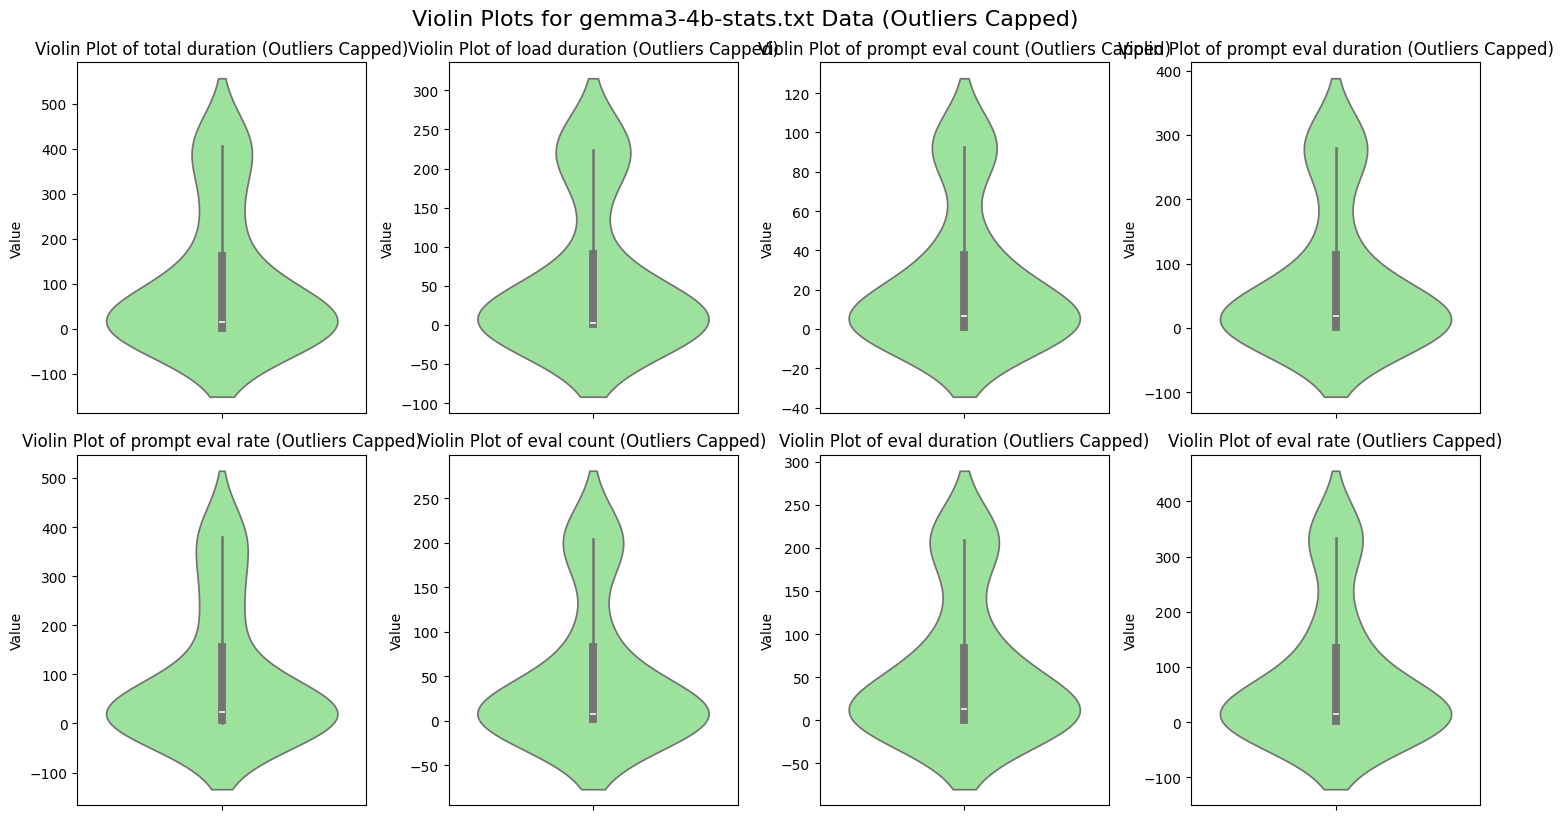

Additional visualizations generated successfully!


In [40]:
def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip values to the defined bounds
    return series.clip(lower=lower_bound, upper=upper_bound)


# Assuming 'df' is populated by your previous script
# For demonstration, let's assume one file name exists
# Replace with the actual file name you want to visualize from your 'df'
file_name = "gemma3-4b-stats.txt" # Make sure this matches a key in your df dictionary

# Safely get the DataFrame for the specified file
# If the file_name key doesn't exist, it will create an empty DataFrame,
# which the 'if not data_frame.empty' check will handle.
data_frame = df.get(file_name, pd.DataFrame())

if not data_frame.empty:
    print("\n--- Generating Additional Visualizations ---")

    # 2. Violin Plots for each variable with outlier capping
    print("Creating Violin Plots for each variable (with outlier capping)...")
    plt.figure(figsize=(15, 8)) # Adjust figure size
    for i, col in enumerate(data_frame.columns):
        plt.subplot(2, 4, i + 1) # Arrange in 2 rows, 4 columns
        # Apply outlier capping to the current column's data before plotting
        capped_data = cap_outliers_iqr(data_frame[col])
        sns.violinplot(y=capped_data, color='lightgreen') # Use capped data for violin plot
        plt.title(f'Violin Plot of {col} (Outliers Capped)') # Indicate capping in title
        plt.ylabel('Value')
    plt.tight_layout()
    plt.suptitle(f'Violin Plots for {file_name} Data (Outliers Capped)', y=1.02, fontsize=16) # Overall title
    plt.show()

    print("Additional visualizations generated successfully!")
else:
    print("\nNo data to visualize. Please ensure the main script ran correctly and populated the DataFrame.")


In [39]:
for key in df:
    print(f"\nFive-Number Summary for: {key}")

    # Select numeric columns only
    sub_df = df[key][[
        'total duration', 
        'load duration', 
        'prompt eval count', 
        'prompt eval duration',
        'prompt eval rate',
        'eval count', 
        'eval duration', 
        'eval rate'
    ]].copy()

    # Ensure all values are numeric
    sub_df = sub_df.apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing values for clarity
    sub_df = sub_df.dropna()

    # Get the 5-number summary
    summary = sub_df.describe().loc[['min', '25%', '50%', '75%', 'max']]
    
    print(summary)


Five-Number Summary for: gemma3-4b-stats.txt
     total duration  load duration  prompt eval count  prompt eval duration  \
min        0.414400       0.000000           0.549300                0.5478   
25%        1.139425       0.979725           1.157500                1.8075   
50%       15.500000       1.790000           6.500000               18.0000   
75%      162.717500      90.000000          37.716575              113.2500   
max    19683.000000   14400.000000        6753.000000             1024.0000   

     prompt eval rate   eval count   eval duration    eval rate  
min          0.544400      0.00000        0.000000     0.000000  
25%          6.250000      1.19615        0.558650     1.636925  
50%         24.060500      7.00000       13.500000    14.719200  
75%        155.770825     82.13410       84.100175   134.522775  
max       2401.000000  10000.00000  1000000.000000  1600.000000  
